# 15-Minute City

authors: Bolzonello Enrico, Carlesso Daniel, Zadro Michele

## Dataset

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import warnings

warnings.filterwarnings('ignore')

In [4]:
nodes = gpd.read_file('data/graph/nodes.shp')
edges = gpd.read_file('data/graph/edges.shp')

nodes = nodes.set_index('osmid')
edges = edges.set_index(['u', 'v', 'key']) 

G = ox.utils_graph.graph_from_gdfs(nodes, edges)

## COVERAGE

In [ ]:
#Create column for every poi type and set it to false for every point other than pois
#set 
#Create new graph with uncovered nodes

## CLUSTERING

Run clustering algorithm to find clusters s.t. each cluster's diameter <= threshold

In [1]:
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN

import osmnx as ox #FOR TEST PURPOSES
import networkx as nx #FOR TEST PURPOSES
ox.config(use_cache=True, log_console=True)

/var/folders/j8/t8w0t18x5_b9rp7q_xf7j7dm0000gn/T/ipykernel_60386/221125511.py:9: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


In [13]:
# parameterize DBSCAN
eps = 2 * 1205  #maximum meters travelled in a 15-minute walk considering average speed of 4.82km/h
minpts = 1  #smallest cluster size allowed

#number of points and maximum number of clusters
n_firms = len(G.nodes())  #number of points
#diam = nx.diameter(G_padova_simplified)
n_clusters = 10  #maximum number of clusters

In [14]:
# randomly select n_clusters number of nodes from the graph
np.random.seed(7)
firm_centers = np.random.choice(G.nodes(), size=n_clusters, replace=False)

# scatter some firms around the selected nodes
xs = []
ys = []
for osmid in firm_centers:
    x = G.nodes[osmid]['x']
    y = G.nodes[osmid]['y']
    np.random.seed(1)
    xs.extend(np.random.normal(loc=x, scale=0.001, size=int(n_firms/len(firm_centers))))
    ys.extend(np.random.normal(loc=y, scale=0.001, size=int(n_firms/len(firm_centers))))
    
firms = pd.DataFrame({'x':xs, 'y':ys})
len(firms)

5460

In [2]:
#FOR TEST PURPOSES
PLACE_NAME = "Padova, Veneto, Italy"
G_padova = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)


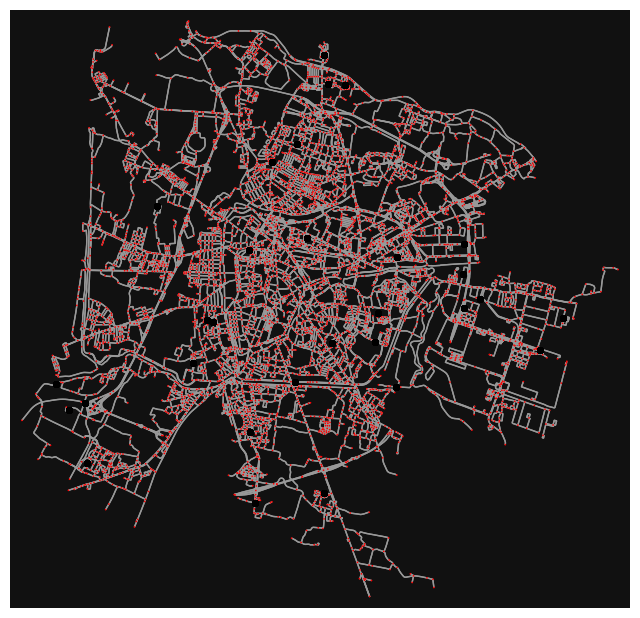

In [22]:
# plot the firms and the points around which they cluster
fig, ax = ox.plot_graph(G_padova_simplified, node_color='red', node_size=1.5, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c='k', marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [15]:
# attach nearest network node to each firm
firms['nn'] = ox.nearest_nodes(G, X=firms['x'], Y=firms['y'])
print(len(firms['nn']))

# we'll get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

5460
10
100


In [16]:
node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=firms['nn'], columns=firms['nn'])
print('{:,.0f}'.format(ndm.size))

# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)

29,811,600


In [61]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.to_numpy().nbytes / 1e6
dense_size

# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6
sparse_size

358.02318

/Users/danielcarlesso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:206: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


6


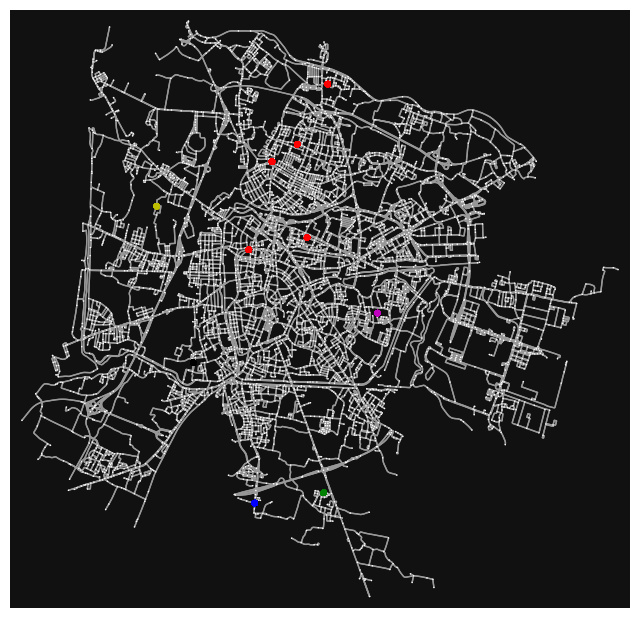

In [17]:
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
firms['network_cluster'] = db.fit_predict(ndm_sparse)

print(len(firms['network_cluster'].unique()))

# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink', 8:'brown', 9:'purple', 10:'violet'}
point_colors = [color_map[c] if c<10 else color_map[(c % 10) - 1] for c in firms['network_cluster']]
ns = [50 if n in firms['nn'].values else 0 for n in G_padova_simplified.nodes()]
fig, ax = ox.plot_graph(G_padova_simplified, node_color='white', node_size=1.2, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [36]:
# save the graph to disk
ox.save_graph_geopackage(G, filepath='data/graph.gpkg')

# save and show the clustered firms data set
firms = firms.reindex(columns=['x', 'y', 'nn', 'network_cluster'])
firms.to_csv('data/clustered.csv', encoding='utf-8', index=False)
print(firms)

                  x             y    nn  network_cluster
0     726325.594930  5.027397e+06  4608                0
1     726325.592694  5.027397e+06  4608                0
2     726325.592778  5.027397e+06  4608                0
3     726325.592233  5.027397e+06  4608                0
4     726325.594172  5.027397e+06  4608                0
...             ...           ...   ...              ...
5455  729357.342004  5.031392e+06  4828               24
5456  729357.342971  5.031392e+06  4828               24
5457  729357.341971  5.031392e+06  4828               24
5458  729357.341018  5.031392e+06  4828               24
5459  729357.342605  5.031392e+06  4828               24

[5460 rows x 4 columns]
